In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/0-9dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/4/3534.png         
  inflating: test/4/3535.png         
  inflating: test/4/3542.png         
  inflating: test/4/3543.png         
  inflating: test/4/3544.png         
  inflating: test/4/3545.png         
  inflating: test/4/3552.png         
  inflating: test/4/3562.png         
  inflating: test/4/3569.png         
  inflating: test/4/3572.png         
  inflating: test/4/3597.png         
  inflating: test/4/3608.png         
  inflating: test/4/3611.png         
  inflating: test/4/3613.png         
  inflating: test/4/3616.png         
  inflating: test/4/3622.png         
  inflating: test/4/3654.png         
  inflating: test/4/3673.png         
  inflating: test/4/3677.png         
  inflating: test/4/3685.png         
  inflating: test/4/3686.png         
  inflating: test/4/3701.png         
  inflating: test/4/3719.png         
  inflating: test/4/3723.png         
  inflating: test/4/3727.png         

Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
#import torchvision.datasets as datasets # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import torch.nn.functional as F # All functions that don't have any parameters
from torch.utils.data import DataLoader, Dataset # Gives easier dataset managment and creates mini batches
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
#from torchvision.transforms import ToTensor, Resize, Normalize, Compose, InterpolationMode

%matplotlib inline


dataset class

In [39]:
import os
from PIL import Image
import glob

class dataset(Dataset):
    
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform

        self.images = sorted(glob.glob(os.path.join(data_path, '*', '*.png')))
        
        # self.data = []
        # self.targets = []
        
        # # Load data and targets
        # for target_class in os.listdir(data_path):
        #     target_path = os.path.join(data_path, target_class)
        #     target_id = int(target_class)
            
        #     for image_file in os.listdir(target_path):
        #         image_path = os.path.join(target_path, image_file)
        #         image = Image.open(image_path)
                
        #         self.data.append(image)
        #         self.targets.append(target_id)
        
        # self.data = np.array(self.data)
        # self.targets = np.array(self.targets)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path)
        
        if self.transform is not None:
            image = self.transform(image)
        
        target = int(os.path.basename(os.path.dirname(image_path)))
        
        return image, target


1. Data loading and normalization

In [ ]:
def load_dataset(train_data_path: str, test_data_path: str, validation_data_path: str, batch_Size: int, Shuffle: bool):
  # Defining transforms for the training data and testing data

  train_transform = transforms.Compose([transforms.Resize((28,28)),
                                        transforms.Grayscale(num_output_channels=1),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.0], std=[0.5])])
  
  test_transform = transforms.Compose([transforms.Resize((28,28)),
                                       transforms.Grayscale(num_output_channels=1),
                                       transforms.ToTensor()])
  
  # Loading dataset using ImageFolder method. Passing transforms in here and using test transform for validation data.

  train_data = dataset(train_data_path, transform=train_transform)
  test_data = dataset(test_data_path, transform=test_transform)
  
  # Here train and test dataloader are created using train_data and test_data objects. Batch size tells how many images are 
  # loaded for one iteration.

  train_loader = DataLoader(train_data, batch_size=batch_Size, shuffle=Shuffle)
  test_loader = DataLoader(test_data)
  
  # Optional case if validation data is given
  validation_transform = transforms.Compose([transforms.Resize((28,28)),
                                             transforms.Grayscale(num_output_channels=1),
                                             transforms.ToTensor()])
  
  validation_data = dataset(validation_data_path, transform=validation_transform)
  validation_loader = DataLoader(validation_data, batch_size=batch_Size)
  
  # Return 

  return train_loader, test_loader, validation_loader


2. Declaring Neural Network

In [ ]:
class Model(nn.Module):
    def __init__(self, no_of_layers, input_dim, neurons_per_layer, dropout):
        super().__init__()

        self.fc_in = nn.Linear(input_dim, neurons_per_layer[0])
        self.layers = nn.ModuleList()
        
        for i in range(no_of_layers - 1):
            self.layers.append(nn.Linear(neurons_per_layer[i], neurons_per_layer[i+1]))

        self.fc_out = nn.Linear(neurons_per_layer[-1], 10)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc_in(x)))
        for j in self.layers:
            x = self.dropout(F.relu(j(x)))
        x = self.fc_out(x)

        return x

  

3. Training

In [30]:
def train(net, train_loader, valid_loader, epochs, loss_func, optimizer, device, visualize):
    train_loss_array = []
    train_acc_array = []
    validation_acc_array = []
    validation_loss_array = []
    prev_valid_acc = 0.0
    
    for epoch in range(epochs):
        net.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        valid_correct = 0
        valid_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            #print(data[0].shape)
            optimizer.zero_grad()
            output = net(data)
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()

            # calculate training accuracy
            predicted = torch.argmax(output, dim=1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

            train_loss += loss.item()

        train_accuracy = train_correct / train_total
        train_acc_array.append(train_accuracy)

        # calculate validation accuracy
        net.eval()
        with torch.no_grad():
            valid_loss = 0.0
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = net(data)
                predicted = torch.argmax(output, dim=1)
                valid_total += target.size(0)
                valid_correct += (predicted == target).sum().item()
                loss = loss_func(output, target)
                valid_loss += loss.item()

            valid_accuracy = valid_correct / valid_total
            validation_acc_array.append(valid_accuracy)

            valid_los = valid_loss / len(valid_loader)
            validation_loss_array.append(valid_los)

            # save the model with current epoch number as the model name
            if valid_accuracy > prev_valid_acc:
                save_model(net, f'model_{epoch+1}')
                prev_valid_acc = valid_accuracy



        epoch_loss = train_loss / len(train_loader)
        train_loss_array.append(epoch_loss)

        print('Epoch {}/{}  Train Loss: {:.6f}  Train Acc: {:.6f}  Valid Loss: {:.6f}  Valid Acc: {:.6f}'.format(
            epoch+1, epochs, epoch_loss, train_accuracy, valid_loss/len(valid_loader), valid_accuracy))
    if visualize:
        train_visualize(loss_array=train_loss_array, accuracy_array=train_acc_array, string='training')
        train_visualize(loss_array=validation_loss_array, accuracy_array=validation_acc_array, string='validation')
        
    return net, train_loss_array, train_acc_array, validation_loss_array, validation_acc_array


4. Save Network

In [31]:
def save_model(model, model_name: str):
    torch.save(model, '{}.pt'.format(model_name))
    

5. Load Network

In [32]:
def load_model(model_file_path: str):
    return torch.load(model_file_path)


6. Testing Step


In [33]:
def test(model, test_loader,loss_func, visualize):
    with torch.no_grad():
        pred = []
        output = []
        data_ = test_loader.dataset
        loss_array = []
        for index, (data, batch_output) in enumerate(test_loader):
            out = model(data)
            pred_ = torch.argmax(out, dim=1)
            pred.append(pred_)
            output.append(batch_output)
            loss = loss_func(out, batch_output)
            loss_array.append(loss.item())

        pred = torch.cat(pred, dim=0)
        output = torch.cat(output, dim=0)

        plt.plot(range(len(loss_array)), loss_array)
        plt.xlabel('no of samples')
        plt.ylabel('loss')
        plt.title('Loss curve for test losses')
        plt.show()
        
        
        correct = (pred == output).sum().item()
        total = output.size(0)
        accuracy = correct/total

    if visualize:
        test_visualize(pred_output=pred, true_output=output, data=data_, accuracy=accuracy)
    return pred


7. Visualize Results


In [34]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
def train_visualize(loss_array, accuracy_array, string):
    fig = plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(range(len(loss_array)), loss_array)
    plt.xlabel('NO. of epochs')
    plt.ylabel('Loss')
    plt.title('Loss curve for '+string)

    plt.subplot(122)
    plt.plot(range(len(accuracy_array)), accuracy_array)
    plt.xlabel('NO. of epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy curve for '+string)
    plt.show()

def test_visualize(pred_output, true_output, data, accuracy):
    n = 0
    for i in range(len(true_output)):
        if pred_output[i] != true_output[i] and n < 5:
            img = data[i][0].cpu().numpy().squeeze()  # convert to NumPy array and remove channel dimension
            plt.imshow(img, cmap='gray')
            plt.xlabel('Predicted output is: {}'.format(pred_output[i]))
            plt.show()
            n += 1

        if i%500 == 0:
            img = data[i][0].cpu().numpy().squeeze()  # convert to NumPy array and remove channel dimension
            plt.imshow(img, cmap='gray')
            plt.xlabel('Predicted output is: {}'.format(pred_output[i]))
            plt.show()

    Confusion_matrix = confusion_matrix(true_output, pred_output)
    F1_score = f1_score(true_output, pred_output, average='macro')

    fig = plt.figure(figsize=(15,5))
    sns.heatmap(Confusion_matrix, annot=True, cmap='Blues')
    plt.show()

    
    print('F1 Score is: {}\n Accuracy is: {}'.format(F1_score, accuracy))


8. Main Function

In [35]:
def main_function(training_path, testing_path, validation_path, input_dim, no_of_hidden_layers, list_of_neurons, optimizer, learning_rate, no_of_epchos, loss_function, batch_size, dropout, Gpu=False, is_training=False, Model_path=None, visualize_results=False, save_Model=False, model_name=None):
    if Gpu and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    # Loading data sets
    train_loader, test_loader, validation_loader = load_dataset(training_path, testing_path, validation_path, batch_size,
                                                                Shuffle=True)

    # training
    if is_training:
        model = Model(no_of_hidden_layers, input_dim=input_dim, neurons_per_layer=list_of_neurons, dropout=dropout)
        optimizer1 = optimizer(model.parameters(), lr=learning_rate)
        model, train_loss_array, train_accuracy_array,validation_loss_array, validation_acc_array = train(net= model,
                                                                                            train_loader=train_loader,
                                                                                          valid_loader=validation_loader,
                                                                                           epochs=no_of_epchos,
                                                                                            loss_func=loss_function,
                                                                                             optimizer=optimizer1,
                                                                                              device=device,
                                                                                               visualize=visualize_results)
    else:
        model = load_model(Model_path)
    
    # Testing
    prediction = test(model=model, test_loader=test_loader,loss_func=loss_function, visualize=visualize_results)

    # Saving model 
    if save_Model:
        save_model(model, model_name=model_name)

    
    

Calling main function

Epoch 1/20  Train Loss: 0.338315  Train Acc: 0.899267  Valid Loss: 0.269943  Valid Acc: 0.956697
Epoch 2/20  Train Loss: 0.153234  Train Acc: 0.958650  Valid Loss: 0.158943  Valid Acc: 0.962739
Epoch 3/20  Train Loss: 0.118097  Train Acc: 0.967967  Valid Loss: 0.141977  Valid Acc: 0.969789
Epoch 4/20  Train Loss: 0.100137  Train Acc: 0.972400  Valid Loss: 0.188152  Valid Acc: 0.961732
Epoch 5/20  Train Loss: 0.086354  Train Acc: 0.976850  Valid Loss: 0.111579  Valid Acc: 0.972810
Epoch 6/20  Train Loss: 0.077761  Train Acc: 0.978700  Valid Loss: 0.086789  Valid Acc: 0.979859
Epoch 7/20  Train Loss: 0.070555  Train Acc: 0.980583  Valid Loss: 0.085059  Valid Acc: 0.981873
Epoch 8/20  Train Loss: 0.065234  Train Acc: 0.982167  Valid Loss: 0.094861  Valid Acc: 0.974824
Epoch 9/20  Train Loss: 0.060311  Train Acc: 0.983300  Valid Loss: 0.088216  Valid Acc: 0.977845
Epoch 10/20  Train Loss: 0.055084  Train Acc: 0.984917  Valid Loss: 0.081735  Valid Acc: 0.980866
Epoch 11/20  Train Loss: 0.05

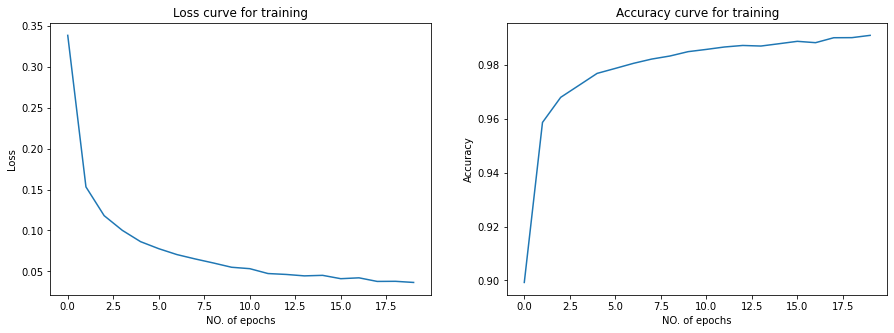

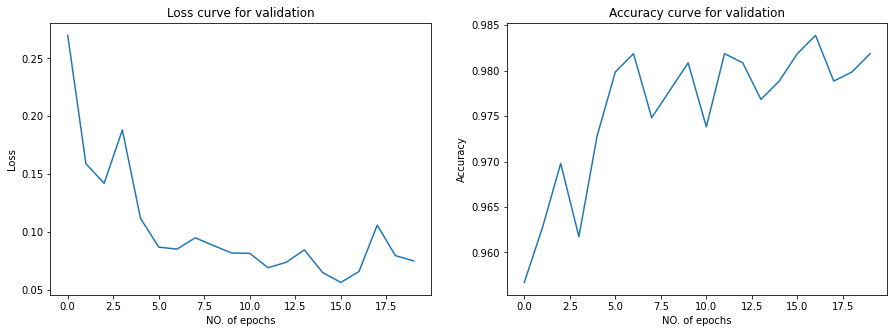

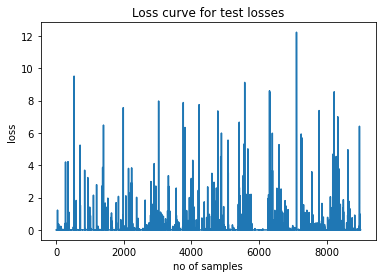

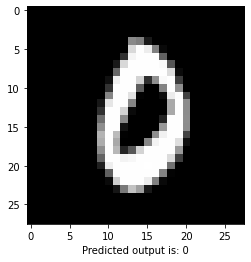

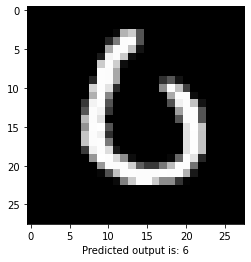

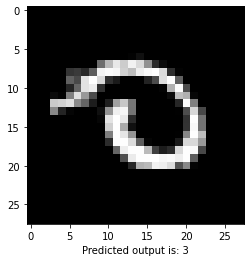

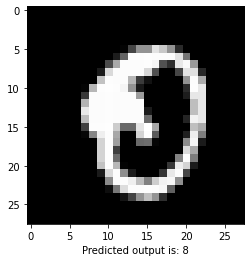

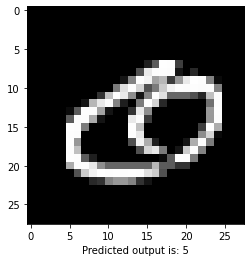

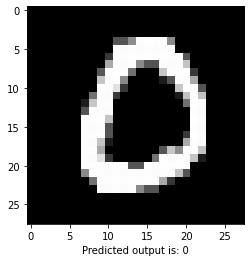

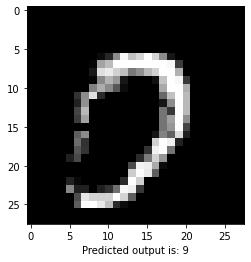

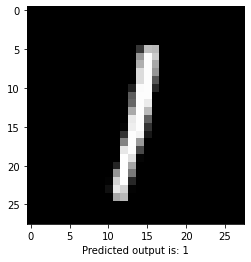

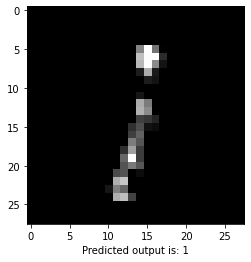

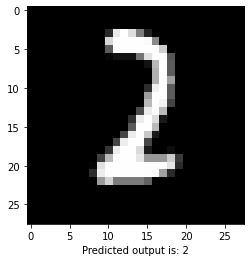

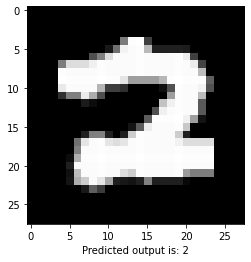

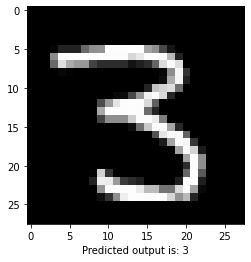

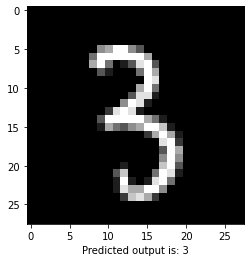

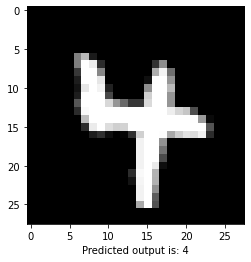

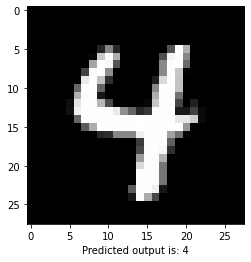

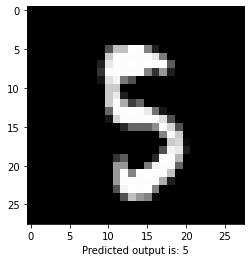

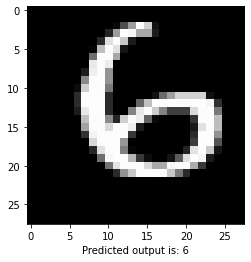

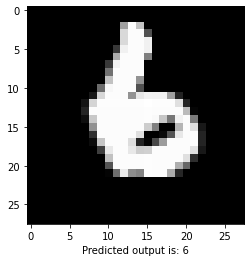

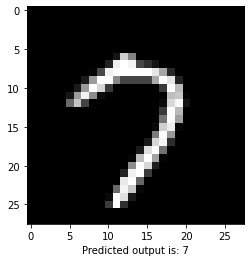

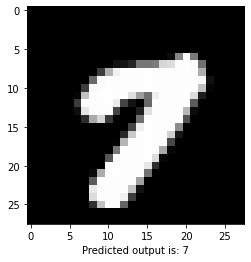

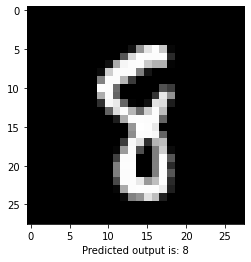

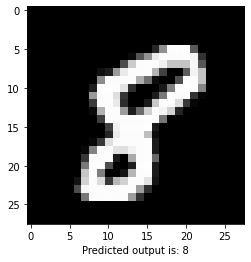

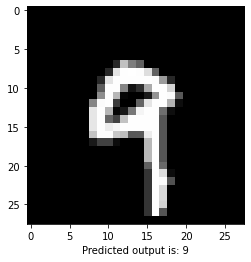

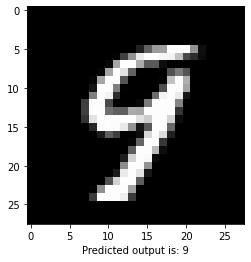

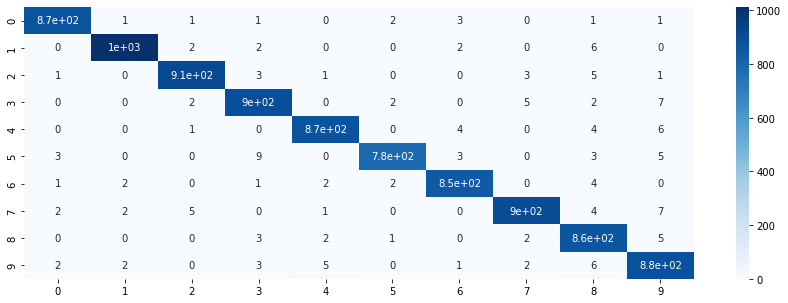

F1 Score is: 0.9822505120884246
 Accuracy is: 0.9823470633951371


In [40]:
#Loss function: Cross-entropy loss
#Optimizer: Adam optimizer
#Learning rate: 0.001-0.01
#Number of epochs: 20-30
#Number of hidden layers: 2-3
#Number of neurons in each hidden layer: 128-256
#batch size: 32-64
#dropout: 0.2-0.5
loss_fun = nn.CrossEntropyLoss()
hiddenlayers = 4
listof_HL = [400,200,100,50]
drop = 0.2
batch = 32
optimizer = torch.optim.Adam
learning = 0.001
epochs = 20


main_function(training_path='/content/train',
              testing_path='/content/test',
              validation_path='/content/validation',
              input_dim=784,
              no_of_hidden_layers=hiddenlayers,
              list_of_neurons=listof_HL, optimizer=optimizer,
              learning_rate=learning, no_of_epchos=epochs,
              loss_function=loss_fun, batch_size=batch,
              dropout=drop, is_training=True,
              visualize_results=True, save_Model=False)